# 2021-05-14-profiling-question-new-partners-initial-analysis
### new partners snapshot date of 2021-05-11

In [4]:
!pip3 install umap-learn --quiet
import pandas as pd
import numpy as np
import pydata_google_auth
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
!pip install git+https://github.com/smazzanti/mrmr --quiet 
from utils.shuqing_all import *
plt.style.use('fivethirtyeight')
five_thrity_eight=[
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",    
]
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import umap
sns.set_palette(five_thrity_eight)
from tqdm import tqdm
from scipy.spatial.distance import cdist
import joblib

In [244]:
SQL= """
SELECT  question.partner_position_id,
position_type,
title,
started_at,
is_active,
date,
question_id,
choice_ids,
feature_table.articles_unique_days_viewed_last_1m
,feature_table.customers_gathered_last_1m
,feature_table.avg_monthly_ri_earned_last_3m
,feature_table.days_logged_into_portal_last_1m
,feature_table.days_since_last_activity,
feature_table.jtc_applications_last_1m
,feature_table.learning_plans_started_last_1m
,feature_table.prospects_unique_days_viewed_last_1m
,times_successfully_supporting_last_1m
FROM `uw-data-models-prod.partner_dataform_models_position.partner_profiling_answers` question
LEFT JOIN 
(SELECT a.snapshot_date
,a.partner_position_id
,b.articles_unique_days_viewed_last_1m
,a.customers_gathered_last_1m
,c.avg_monthly_ri_earned_last_3m
,d.days_logged_into_portal_last_1m
,e.days_since_last_activity
,f.jtc_applications_last_1m 
,g.learning_plans_started_last_1m
,h.is_live
,i.prospects_unique_days_viewed_last_1m
,j.times_successfully_supporting_last_1m
FROM `uw-data-models-prod.partner_dataform_models_feature_catalogue.customers_gathered_last_period` a
LEFT JOIN `uw-data-models-prod.partner_dataform_models_feature_catalogue.articles_unique_days_viewed_last_period`b
ON a.snapshot_date = b.snapshot_date AND a.partner_position_id = b.partner_position_id
LEFT JOIN `uw-data-models-prod.partner_dataform_models_feature_catalogue.avg_monthly_ri_earned_last_period` c
ON b.snapshot_date =c.snapshot_date AND c.partner_position_id = b.partner_position_id
LEFT JOIN `uw-data-models-prod.partner_dataform_models_feature_catalogue.days_logged_into_portal_last_period` d
ON c.snapshot_date = d.snapshot_date AND c.partner_position_id = d.partner_position_id
LEFT JOIN `uw-data-models-prod.partner_dataform_models_feature_catalogue.days_since_last_activity` e
ON d.snapshot_date = e.snapshot_date AND d.partner_position_id = e.partner_position_id
LEFT JOIN `uw-data-models-prod.partner_dataform_models_feature_catalogue.jtc_applications_last_period` f
ON e.snapshot_date = f.snapshot_date AND f.partner_position_id = e.partner_position_id
LEFT JOIN `uw-data-models-prod.partner_dataform_models_feature_catalogue.learning_plans_started_last_period` g
ON f.snapshot_date = g.snapshot_date AND f.partner_position_id = g.partner_position_id
LEFT JOIN  `uw-data-models-prod.partner_dataform_models_feature_catalogue.prospects_unique_days_viewed_last_period` i
ON i.snapshot_date = g.snapshot_date AND i.partner_position_id = g.partner_position_id
LEFT JOIN  `uw-data-models-prod.partner_dataform_models_feature_catalogue.times_successfully_supporting_last_period`  j
ON j.snapshot_date = i.snapshot_date AND j.partner_position_id = i.partner_position_id

LEFT JOIN (
SELECT snapshot_date
,partner_position_id
,is_live
FROM 
(SELECT partner_position_id
,snapshot_date
,is_live
,ROW_NUMBER() OVER (PARTITION BY partner_position_id ORDER BY snapshot_date DESC) num
FROM `uw-data-models-prod.partner_dataform_models_feature_catalogue.partner_position_live` 
# WHERE partner_position_id = '668079'
) tmp
WHERE tmp.num =1 
) h
ON  a.partner_position_id = h.partner_position_id    #'2021-05-11'
WHERE is_live = true AND a.snapshot_date = '2021-08-04'
ORDER BY snapshot_date DESC ) feature_table
ON question.partner_position_id = feature_table.partner_position_id


"""

In [245]:
df=download_data('uw-data-warehouse-prod',sign='>',time_constraint="'2021-04-18'",query=SQL)

Downloading:   0%|          | 0/3712 [00:00<?, ?rows/s]

In [246]:
df=df.loc[df.is_active==1]
df.drop(['started_at','is_active','date'],axis=1,inplace=True)

/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [247]:
def check_null(df):
    flag=df.isnull().sum().any()
    if flag ==True:
        total=df.isnull().sum().sort_values(ascending=False)
        percent=(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
        missing=pd.concat([total,percent],keys=['total','percent'],axis=1)
        
        data_type=[]
        for col in df.columns:
            dtype=df[col].dtype
            data_type.append(dtype)
        missing['dtype']=data_type
        return missing
    else:
        return False         

In [248]:
## Model_features are at least 82% null, we need to drop those columns 
check_null(df)

,total,percent,dtype
articles_unique_days_viewed_last_1m,1412,1.0,object
customers_gathered_last_1m,1412,1.0,object
avg_monthly_ri_earned_last_3m,1412,1.0,object
days_logged_into_portal_last_1m,1412,1.0,object
days_since_last_activity,1412,1.0,object
jtc_applications_last_1m,1412,1.0,float64
learning_plans_started_last_1m,1412,1.0,float64
prospects_unique_days_viewed_last_1m,1412,1.0,float64
times_successfully_supporting_last_1m,1412,1.0,float64
partner_position_id,0,0.0,float64


In [249]:
question=df.pivot(index=['partner_position_id','position_type','title'],columns='question_id',values='choice_ids').reset_index()

In [250]:
for answer in ['DEBT', 'EDUCATION', 'HOLIDAY', 'INCOME', 'OTHER']:
    question[f'SPEND_MONTHLY_INCOME_ANSWER_{answer}']=question.HOW_TO_SPEND_MONTHLY_INCOME.str.contains(answer)
for col in ['SPEND_MONTHLY_INCOME_ANSWER_DEBT',
       'SPEND_MONTHLY_INCOME_ANSWER_EDUCATION',
       'SPEND_MONTHLY_INCOME_ANSWER_HOLIDAY',
       'SPEND_MONTHLY_INCOME_ANSWER_INCOME',
       'SPEND_MONTHLY_INCOME_ANSWER_OTHER']:
    le=LabelEncoder()
    question[col]=le.fit_transform(question[col])

question.drop(['HOW_TO_SPEND_MONTHLY_INCOME'],axis=1,inplace=True)
question['spend_monthly_income_total_answer_count']=question.SPEND_MONTHLY_INCOME_ANSWER_DEBT+question.SPEND_MONTHLY_INCOME_ANSWER_EDUCATION+question.SPEND_MONTHLY_INCOME_ANSWER_HOLIDAY+question.SPEND_MONTHLY_INCOME_ANSWER_INCOME+question.SPEND_MONTHLY_INCOME_ANSWER_OTHER

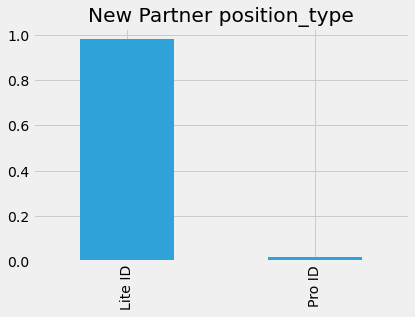

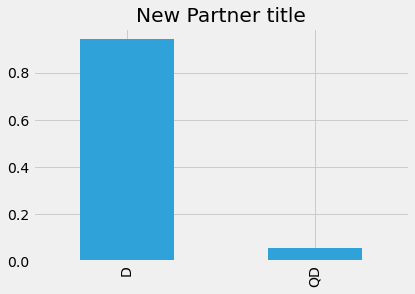

In [9]:
for col in ['position_type','title']:
    f,axes=plt.subplots(1,1)
    ax=question[col].value_counts(normalize=True).plot(kind='bar')
    ax.set_title('New Partner '+ col)

In [176]:
question_columns=['HOW_MANY_IN_HOUSEHOLD', 'HOW_MUCH_MONTHLY_INCOME',
       'HOW_MUCH_TIME_TO_COMMIT','SPEND_MONTHLY_INCOME_ANSWER_DEBT',
       'SPEND_MONTHLY_INCOME_ANSWER_EDUCATION',
       'SPEND_MONTHLY_INCOME_ANSWER_HOLIDAY',
       'SPEND_MONTHLY_INCOME_ANSWER_INCOME',
       'SPEND_MONTHLY_INCOME_ANSWER_OTHER','spend_monthly_income_total_answer_count']

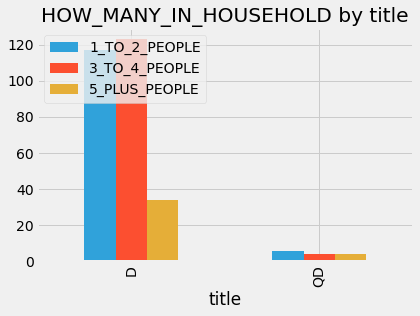

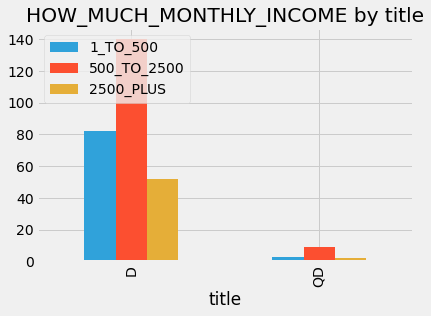

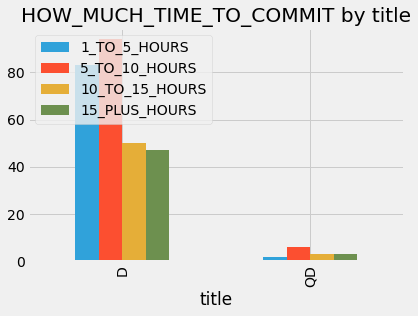

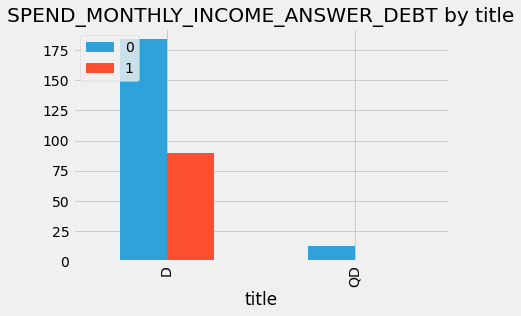

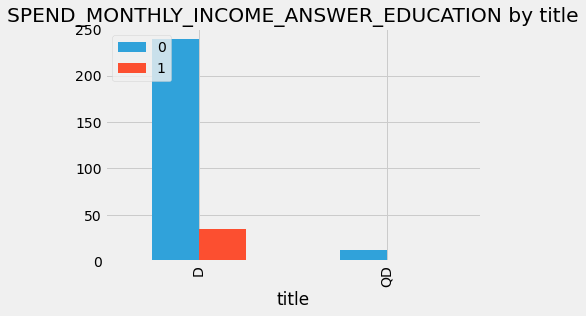

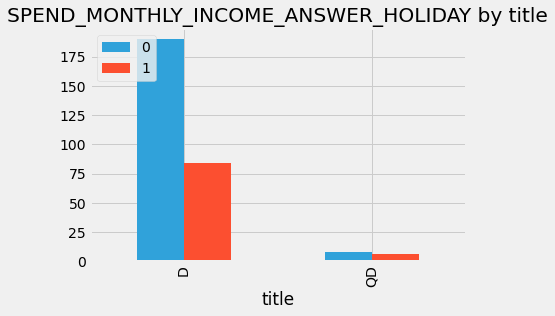

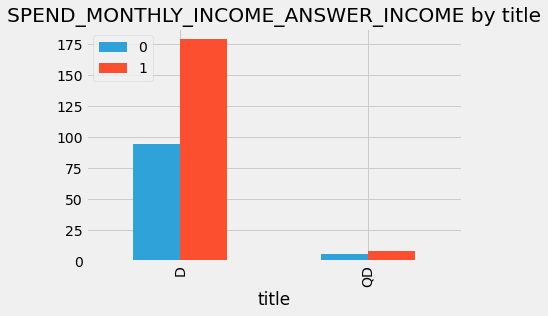

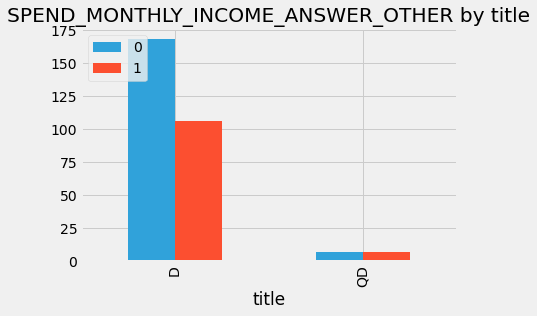

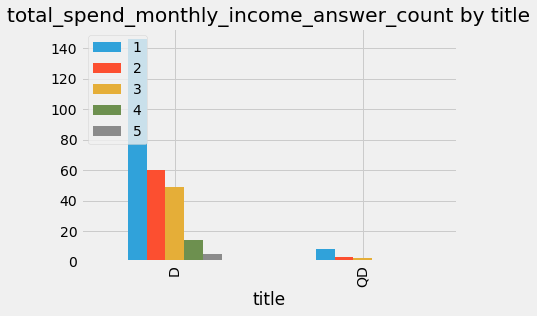

In [242]:
plot_columns(question,question_columns,'title')

### Summary
- Total 288 responses, 98% of new partners are Lite
- Household size: 3-4 people, monthly income: 500-2500, time to commit: 5-10 hours 
- Spend monthly income : income or other

# Clustering

## Feature Engineering

In [251]:
cat_features=question.select_dtypes(include=['object']).columns.drop(['partner_position_id',
            'position_type','title'])

In [252]:
ordinals={'HOW_MANY_IN_HOUSEHOLD':['1_TO_2_PEOPLE','3_TO_4_PEOPLE','5_PLUS_PEOPLE'],
 'HOW_MUCH_MONTHLY_INCOME':['1_TO_500','500_TO_2500','2500_PLUS'],
'HOW_MUCH_TIME_TO_COMMIT':['1_TO_5_HOURS','5_TO_10_HOURS','10_TO_15_HOURS','15_PLUS_HOURS']         }

In [253]:
def categorise_cat(df,ordinals,cat_features):
    cat_dict={}
    for c in cat_features:
        categories=ordinals.get(c)
        df[c]=pd.Categorical(df[c],categories=categories,ordered=categories is not None)
        cats=df[c].cat.categories
        cat_dict[c]=cats
    return cat_dict

def encoding_cat(df,ordinals,cat_features):
    for col in cat_features:
        df[col]=df[col].cat.codes
    return df 

In [254]:
cat_dicts=categorise_cat(question,ordinals,cat_features)

In [255]:
train=question.iloc[:,3:]
train=encoding_cat(train,ordinals,cat_features)

In [256]:
question.to_csv('new_partners_question.csv',index=False)

## Dimension Reduction 

### T-SNE

In [19]:
tsne=TSNE(verbose=1,perplexity=40,random_state=42)

In [20]:
X_embedded=tsne.fit_transform(train)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 352 samples in 0.040s...
[t-SNE] Computed neighbors for 352 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 352 / 352
[t-SNE] Mean sigma: 0.913604
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.009293
[t-SNE] KL divergence after 1000 iterations: 0.600333


In [21]:
distortions=[]
K=range(2,30)
for k in tqdm(K):
    kmeans=KMeans(n_clusters=k,random_state=42).fit(X_embedded)
    kmeans.fit(X_embedded)
    distortions.append(sum(np.min(cdist(X_embedded,kmeans.cluster_centers_,'euclidean'),axis=1))/train.shape[0])

100%|██████████| 28/28 [00:07<00:00,  3.77it/s]


Text(0.5, 1.0, 'The Elbow Curve of Optimal k')

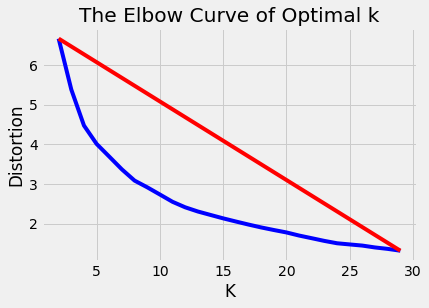

In [22]:
X_line=[K[0],K[-1]]
y_line=[distortions[0],distortions[-1]]
plt.plot(K,distortions,'b-')
plt.plot(X_line,y_line,'r-')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.title('The Elbow Curve of Optimal k')

In [23]:
k=3
kmeans=KMeans(n_clusters=k,random_state=42)
y_pred=kmeans.fit_predict(X_embedded)
question['y_pred']=y_pred

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 't_SNE with Kmeans Labels')

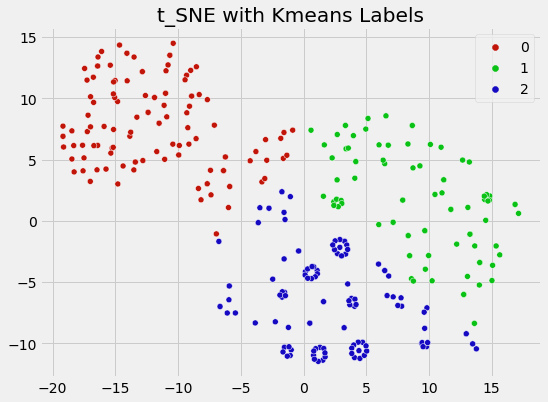

In [24]:
plt.figure(figsize=(8,6))
sns.scatterplot(X_embedded[:,0],X_embedded[:,1],
    palette=sns.hls_palette(k, l=.4, s=.9),hue=y_pred).set_title('t_SNE with Kmeans Labels')

### UMAP

In [257]:
import umap

In [238]:
umap=umap.UMAP()
umap=umap.fit(train)
umap_embedding=umap.transform(train)
# umap_embedding=umap.fit_transform(train)
k=3
kmeans=KMeans(n_clusters=k,random_state=42)
y_umap_pred=kmeans.fit_predict(umap_embedding)
question['umap_y_pred']=y_umap_pred

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'UMAP with K-Means Labels for New Partners')

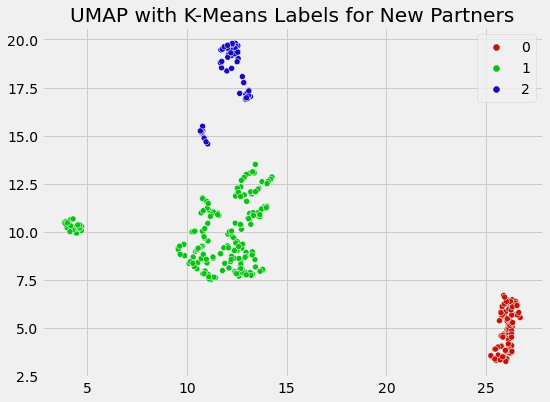

In [239]:
plt.figure(figsize=(8,6))
k=3
sns.scatterplot(umap_embedding[:,0],umap_embedding[:,1],
               palette=sns.hls_palette(k,l=.4,s=.9),hue=y_umap_pred).set_title('UMAP with K-Means Labels for New Partners')

In [240]:
joblib.dump(umap,'new_partners_umap_embedding_model')
joblib.dump(kmeans,'new_partners_kmeans_model')

['new_partners_kmeans_model']

In [241]:
umap=joblib.load('new_partners_umap_embedding_model')
km=joblib.load('new_partners_kmeans_model')
new_partners_umap_embedding=umap.transform(train)

In [316]:
umap=joblib.load('new_partners_umap_embedding_model')
km=joblib.load('new_partners_kmeans_model')
new_partners_umap_embedding=umap.transform(train)
new_partners_u_map_pred=km.predict(new_partners_umap_embedding)

In [318]:
pd.DataFrame(new_partners_umap_embedding).to_csv('new_partners_umap_embedding.csv')
pd.DataFrame(new_partners_u_map_pred).to_csv('new_partners_u_map_pred.csv')

In [261]:
question['umap_y_pred']=new_partners_u_map_pred

## UMAP +Kmeans Visualisation

In [ ]:
# def synthetic_clusters(embedding):
#     group_0_index=np.where((embedding[:,0]>30))
#     group_1_index=np.where((embedding[:,0]<30)&(embedding[:,0]>19))
#     group_2_index=np.where((embedding[:,0]<20))
#     group_0=pd.DataFrame(embedding[group_0_index],columns=list('01')).set_index(np.array(group_0_index)[0])
#     group_0['cluster']=0
#     group_0=pd.DataFrame(group_0,columns=['0','1','cluster'])
#     group_1=pd.DataFrame(embedding[group_1_index],columns=list('01')).set_index(np.array(group_1_index)[0])
#     group_1['cluster']=1
#     group_1=pd.DataFrame(group_1,columns=['0','1','cluster'])
#     group_2=pd.DataFrame(embedding[group_2_index],columns=list('01')).set_index(np.array(group_2_index)[0])
#     group_2['cluster']=2
#     group_2=pd.DataFrame(group_2,columns=['0','1','cluster'])
#     synthetic_clusters=group_0.append(group_1).append(group_2).sort_index()
#     return synthetic_clusters     


/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'UMAP with K-Means Labels for New Partners')

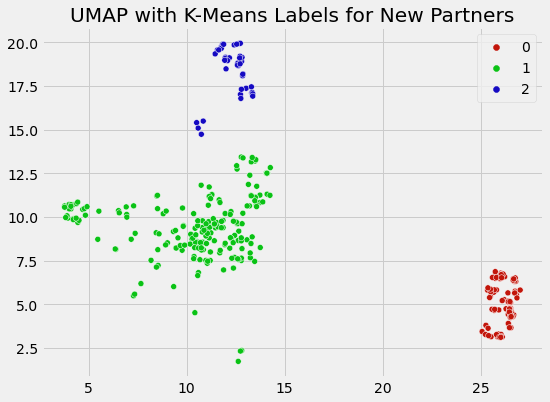

In [259]:
plt.figure(figsize=(8,6))
k=3
sns.scatterplot(new_partners_umap_embedding[:,0],new_partners_umap_embedding[:,1],
               palette=sns.hls_palette(k,l=.4,s=.9),hue=new_partners_u_map_pred).set_title('UMAP with K-Means Labels for New Partners')

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'UMAP with K-Means Labels for New Partners')

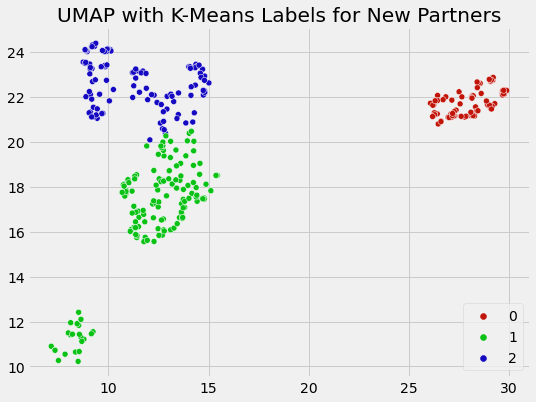

In [36]:
plt.figure(figsize=(8,6))
k=3
sns.scatterplot(new_partners_umap_embedding[:,0],new_partners_umap_embedding[:,1],
               palette=sns.hls_palette(k,l=.4,s=.9),hue=new_partners_u_map_pred).set_title('UMAP with K-Means Labels for New Partners')

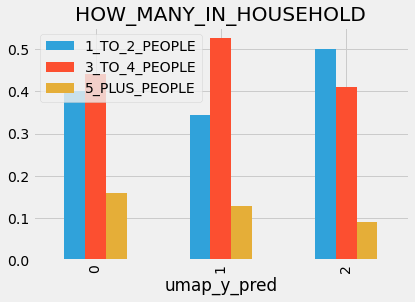

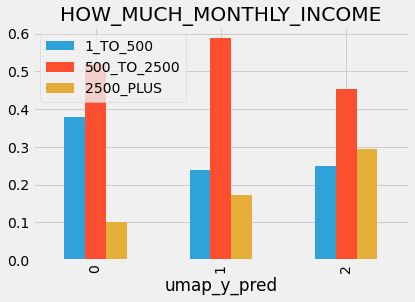

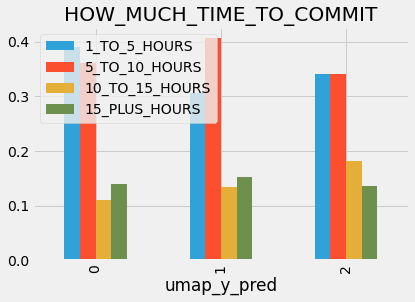

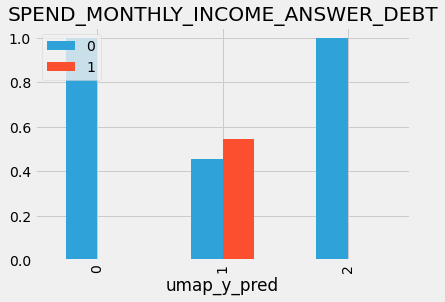

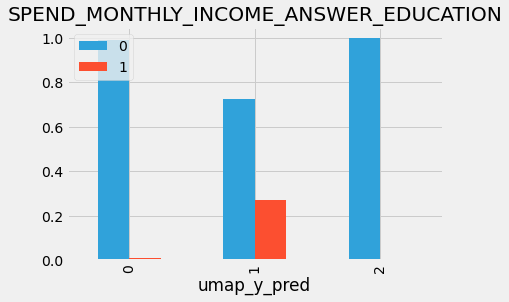

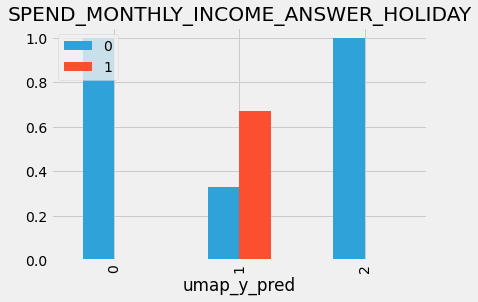

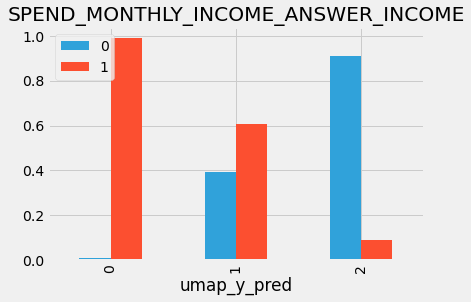

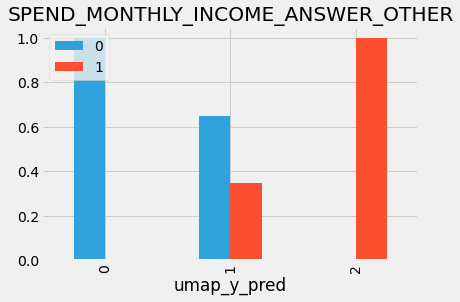

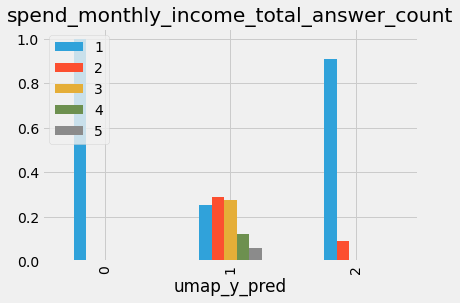

In [262]:
plot_columns(question,question_columns,'umap_y_pred')

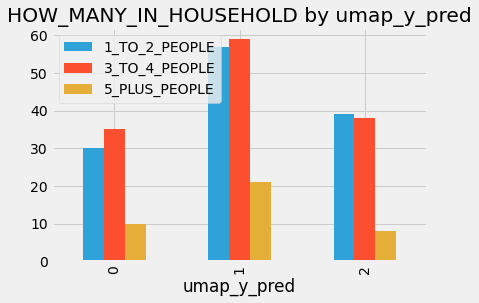

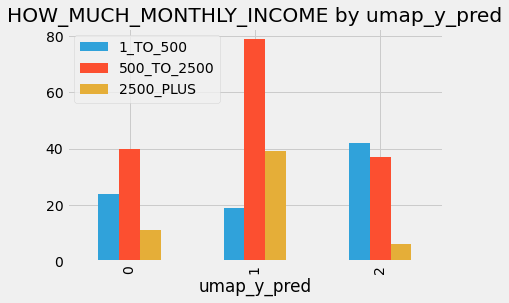

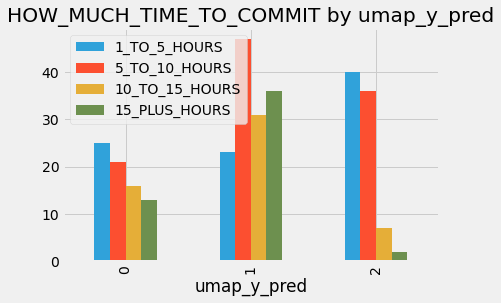

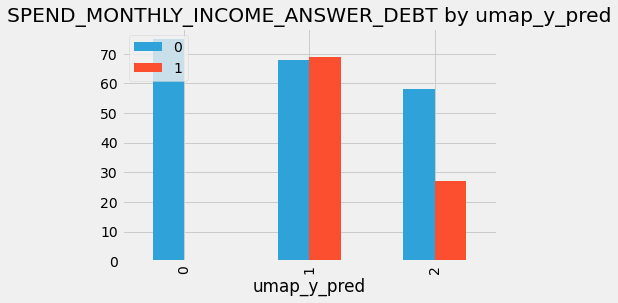

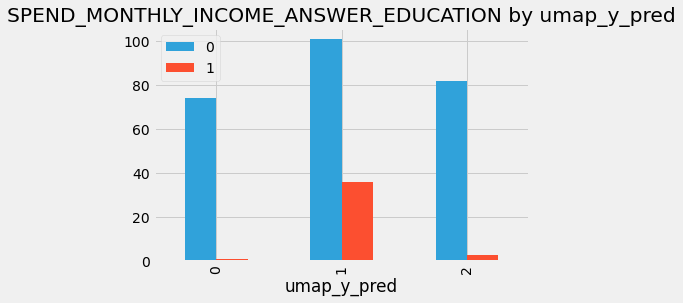

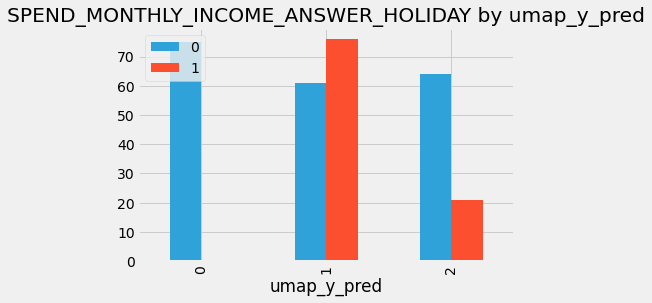

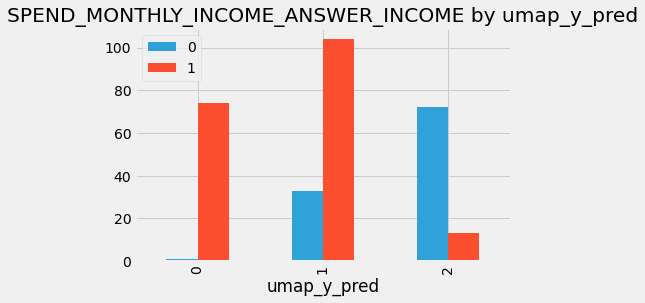

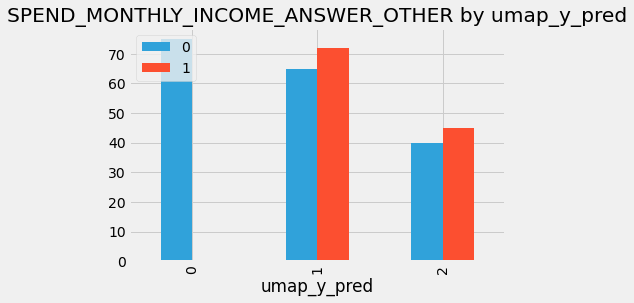

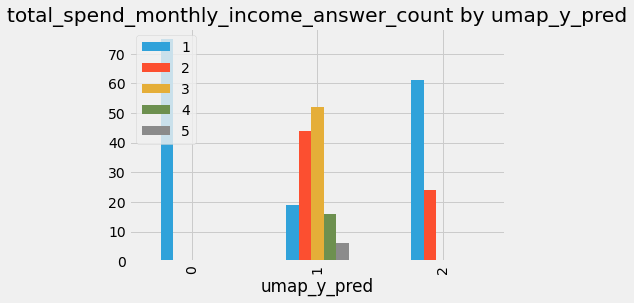

In [24]:
## {group 0: time to commit evenly distributed
#            monthly income pay INCOME, least motivations among 3 clusters 
 #  group 1: predominantly higher income 500-2500, 2500+,
##           time to commit: 5-10 hrs,
#            highly motivated monthly income pay DEBT,HOLIDAY,INCOME education,  
##   group 2: time to commit 1-5 hrs max
#             monthly income pay holiday, others}
# transition: group 0 -> group 2 -> group 1 

plot_columns(question,question_columns,'umap_y_pred')

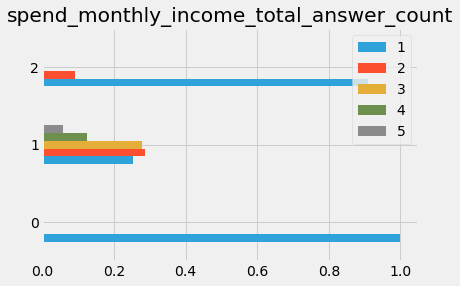

In [314]:
f,ax=plt.subplots(figsize=(6,4))
pd.crosstab(question.umap_y_pred,question.spend_monthly_income_total_answer_count).div(pd.crosstab(question.umap_y_pred,question.spend_monthly_income_total_answer_count).sum(axis=1),axis=0).plot(kind='barh',ax=ax)
plt.ylabel('')
ax.set_title('spend_monthly_income_total_answer_count')                                                                                               
ax.legend(loc='upper right')


In [271]:
question.umap_y_pred.value_counts()

1    209
0    100
2     44
Name: umap_y_pred, dtype: int64

In [36]:
## {group 0: predominantly 3-4 people, time to commit high 10 hr +,income driven
##  group 1: time to commit low end but willing to put in hrs, debt holiday many motivatins driven       
## group 2: more lower income buckets <2500, time to commit low 1-5 hrs , not clear driven motivation}
# plot_columns(question,'y_pred')

In [85]:
question.to_pickle('umap_question_clustering_new_partnerids.pkl')

In [35]:
# pd.read_pickle('umap_question')

## UMAP Grouping Summary

- group 0: time to commit evenly distributed,monthly income pay INCOME, least motivations among 3 clusters 
- group 1: predominantly higher income 500-2500, 2500+, time to commit: 5-10 hrs,highly motivated monthly income pay DEBT,HOLIDAY,INCOME education,  
- group 2: time to commit 1-5 hrs max, monthly income pay holiday, others
- transition: group 0 -> group 2 -> group 1 

## Synthetic Clustering

In [87]:
question=pd.read_csv('new_partners_question.csv')

In [88]:
new_partners_umap_embedding=pd.read_csv('new_partners_umap_embedding.csv')

In [ ]:
new_partners_umap_embedding=new_partners_umap_embedding.iloc[:,1:]
new_partners_synthetic_clusters=synthetic_clusters(new_partners_umap_embedding.values)

In [293]:
new_partners_synthetic_clusters=synthetic_clusters(new_partners_umap_embedding)

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, '')

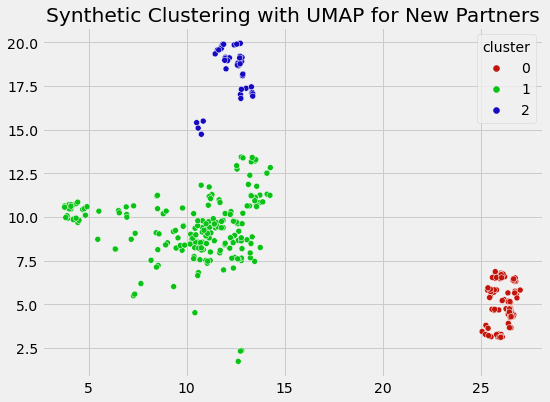

In [294]:
plt.figure(figsize=(8,6))
sns.scatterplot(new_partners_synthetic_clusters.iloc[:,0],new_partners_synthetic_clusters.iloc[:,1],
                palette=sns.hls_palette(new_partners_synthetic_clusters.cluster.nunique(),l=.4,s=.9),hue=new_partners_synthetic_clusters.loc[:,'cluster']).set_title('Synthetic Clustering with UMAP for New Partners')
plt.xlabel('')
plt.ylabel('')

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, '')

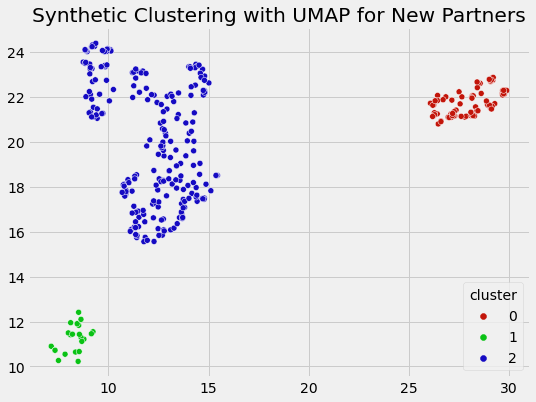

In [270]:
plt.figure(figsize=(8,6))
sns.scatterplot(new_partners_synthetic_clusters.iloc[:,0],new_partners_synthetic_clusters.iloc[:,1],
                palette=sns.hls_palette(3,l=.4,s=.9),hue=new_partners_synthetic_clusters.loc[:,'cluster']).set_title('Synthetic Clustering with UMAP for New Partners')
plt.xlabel('')
plt.ylabel('')

In [295]:
question.umap_y_pred.value_counts()

1    209
0    100
2     44
Name: umap_y_pred, dtype: int64

In [61]:
question['synthetic_clusters']=new_partners_synthetic_clusters.cluster
question.synthetic_clusters.value_counts(dropna=False)

2    242
0    100
1     59
Name: synthetic_clusters, dtype: int64

In [82]:
question.to_csv('question_for_miko.csv',index_label='question_id',index=True)

In [187]:
question=pd.read_csv('question_for_miko.csv')
question=question.iloc[:,1:]

In [265]:
barh_columns=question_columns[3:-1]

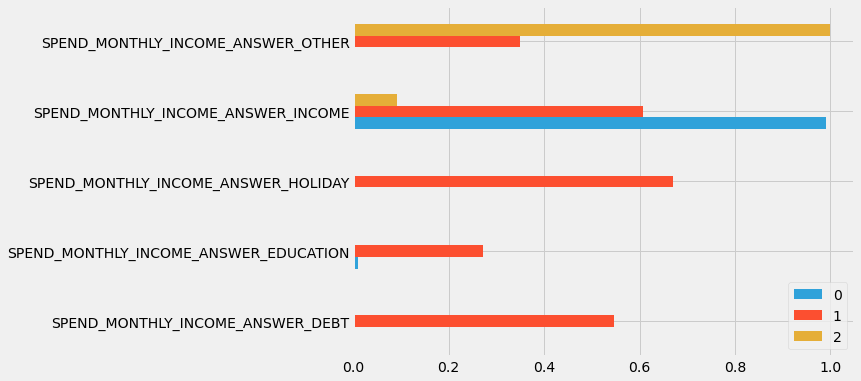

In [296]:
plot_all_columns_plot(question,'umap_y_pred',barh_columns)

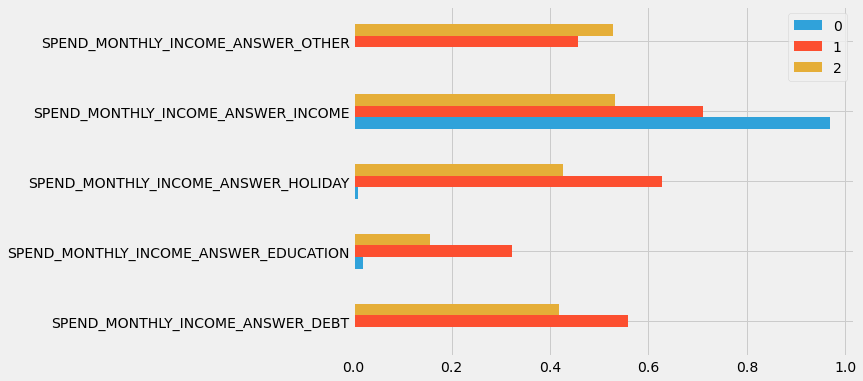

In [229]:
plot_all_columns_plot(question,'umap_y_pred',barh_columns)

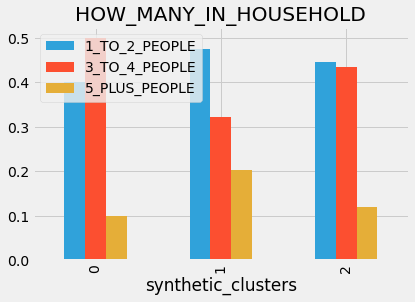

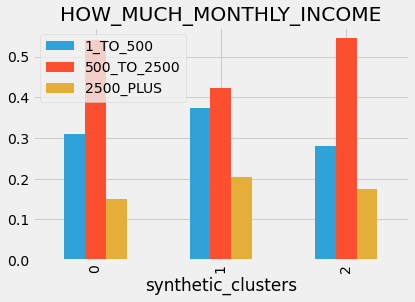

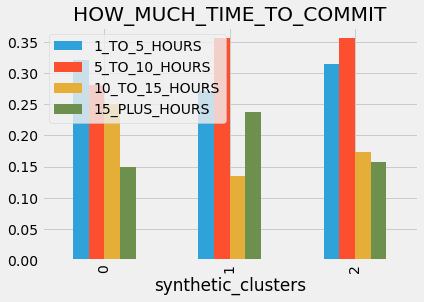

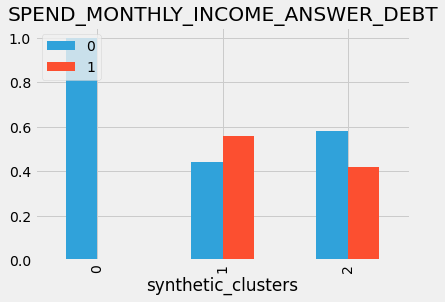

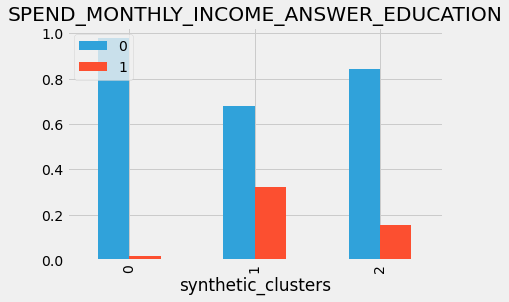

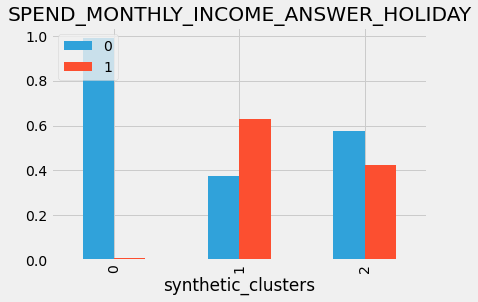

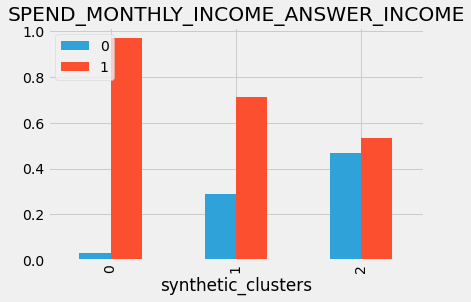

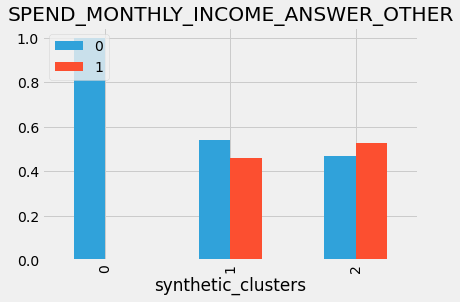

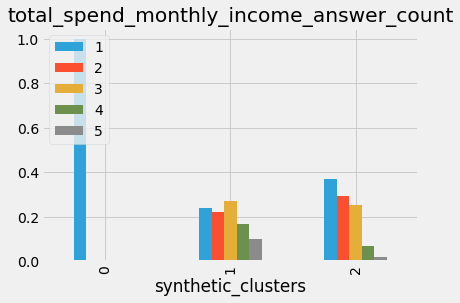

In [132]:
plot_columns(question,question_columns,'synthetic_clusters')

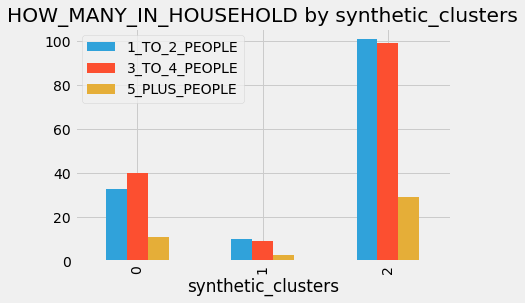

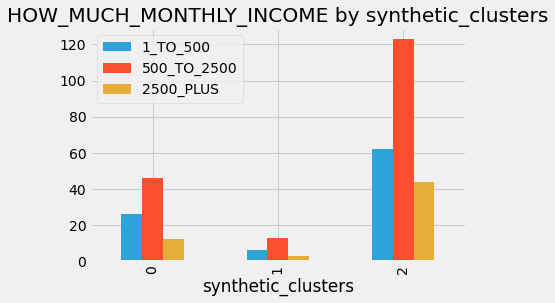

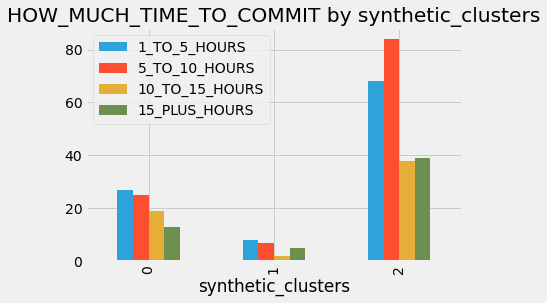

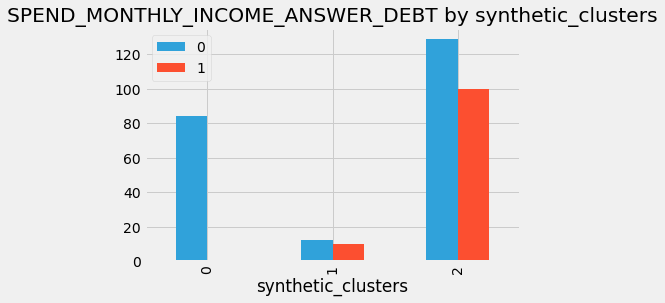

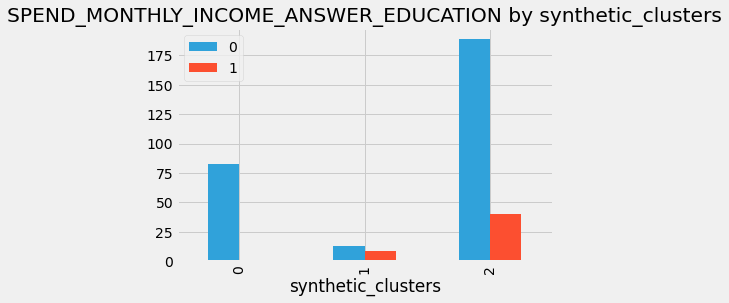

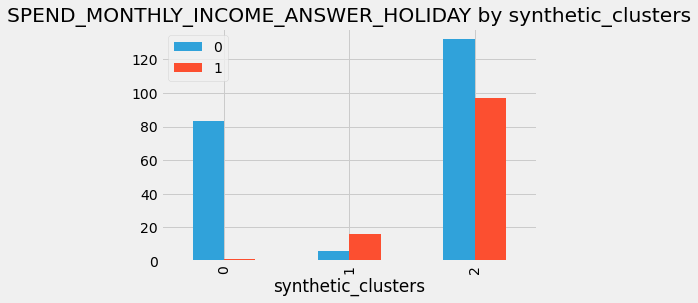

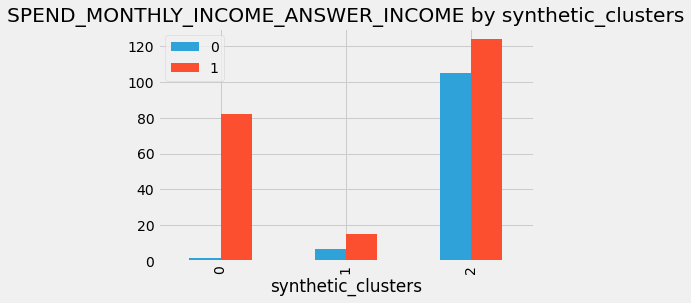

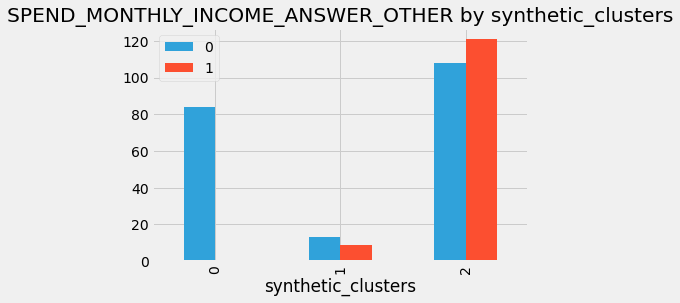

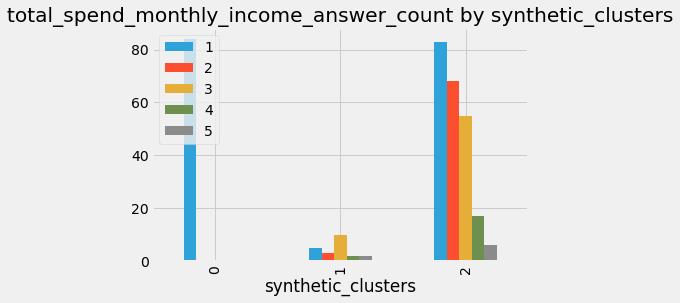

In [272]:
plot_columns(question,question_columns,'synthetic_clusters')

## Summary:
- Based on synthetic clustering,what used to be in umap_kmeans_cluster_1 move to cluster 2, ie the area between (16,20) which is the main driver of traits behind umap cluster_1. Hence cluster 2 is the cluster 1 for this approach. It has exactly the same traits of being eager willing to put in hours and highly motivated. 
- Cluster 0 is only motivated by income and has the least motivation
- Cluster 1 is unwilling to put in hours but say they are highly motivated, they are people who are just excited about new opprotunities but may not follow through